In [ ]:
!pip install monai # 3D data의 augumentation에 대한 많은 정보를 제공함.

  Obtaining dependency information for monai from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00 0:00:01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import os
print(os.getcwd())

/kaggle/working


# monai
* 기본적으로 3D data나 medical image에 aug에서는 gray scale이나 hu value의 수정이 필요하기 때문에 전처리등 필요한게 너무 많다.
* 이를 해결하기위해서 전처리에 유용한 monai에 대해서 알아보자.

In [ ]:
import monai
from monai.apps import DecathlonDataset, download_and_extract
from monai.data import DataLoader, Dataset
from monai.transforms import (
    EnsureChannelFirstd, ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged, ## nifiti, dicom image 읽어오기
    Spacingd, ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd, ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged, # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf, ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd, ## Foreground부분만 남기는 방법
    Rand3DElasticd, ## 3D 모양으로 Elastic Transform
    RandAffined, ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated, ## random roatate
    RandFlipd,

)
import tempfile
from monai.visualize.utils import (
    blend_images,## label과 Image를 합친 영상
    matshow3d ## 3d image의 visulization
)
import matplotlib.pyplot as plt

* Monai의 경우 이미지를 다운로드 받기에 용이하다.
* 새로운 3d image를 다운로드 해보자.

In [ ]:
download = True
if download:
    directory = os.environ.get("MONAI_DATA_DIRECTORY")
    root_dir = tempfile.mkdtemp() if directory is None else directory # 임시 폴더
    print(f"root dir is: {root_dir}")

    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar" # challenge dataset
#     md5 = "8afd997733c7fc0432f71255ba4e52dc"

    compressed_file = os.path.join(root_dir, "Task02_Heart.tar")
    data_dir = os.path.join(root_dir, "Task02_Heart")
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, root_dir)


root dir is: /tmp/tmppddxayzs


Task02_Heart.tar: 435MB [00:26, 17.1MB/s]                               

2023-12-16 10:24:41,100 - INFO - Downloaded: /tmp/tmppddxayzs/Task02_Heart.tar
2023-12-16 10:24:41,101 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmppddxayzs/Task02_Heart.tar.
2023-12-16 10:24:41,102 - INFO - Writing into directory: /tmp/tmppddxayzs.


In [ ]:
ls /tmp/tmppddxayzs/Task02_Heart/imagesTr # nifti file

la_003.nii.gz*  la_009.nii.gz*  la_016.nii.gz*  la_020.nii.gz*  la_024.nii.gz*
la_004.nii.gz*  la_010.nii.gz*  la_017.nii.gz*  la_021.nii.gz*  la_026.nii.gz*
la_005.nii.gz*  la_011.nii.gz*  la_018.nii.gz*  la_022.nii.gz*  la_029.nii.gz*
la_007.nii.gz*  la_014.nii.gz*  la_019.nii.gz*  la_023.nii.gz*  la_030.nii.gz*


In [ ]:
train_images = list((Path(data_dir)/"imagesTr").glob("*.nii.gz"))
train_labels = list((Path(data_dir)/"labelsTr").glob("*.nii.gz"))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': PosixPath('/tmp/tmppddxayzs/Task02_Heart/imagesTr/la_007.nii.gz'),
 'label': PosixPath('/tmp/tmppddxayzs/Task02_Heart/labelsTr/la_007.nii.gz')}

본격적으로 이미지를 읽어보자.

image shape: torch.Size([1, 320, 320, 110])
label shape: torch.Size([1, 320, 320, 120])
pixel spacing: tensor([1.2500, 1.2500, 1.3700], dtype=torch.float64)


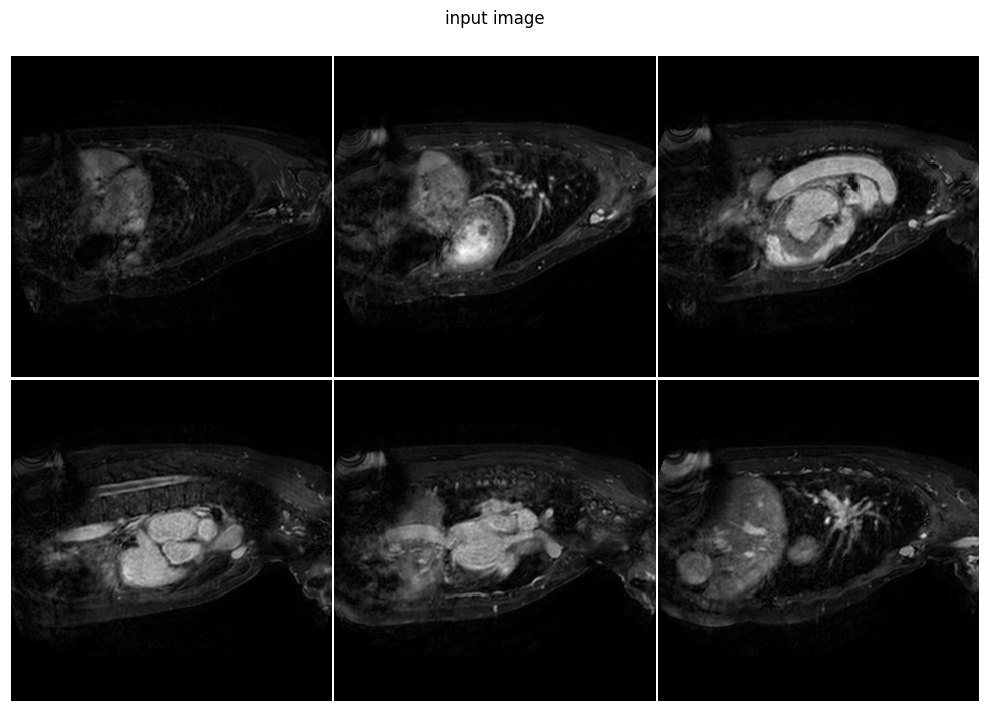

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
    ])
dataset = Dataset(data=val_data_dicts, transform=transform)

print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20], # 20장씩 건너뛰게 됨.
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)
# pixel spacing에서 1.25, 1.25, 1.37은 각각의 픽셀간의 거리를 나타냄.
# pixel spacing을 늘려보자!

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(2, 2, 3), mode=("bilinear", "nearest"))
    ])
dataset = Dataset(data=val_data_dicts, transform=transform)

image의 scale을 spacing에 따라 resampling을 함으로써 작은 object에 크게 학습을 할수 있게 되어진다

image shape: torch.Size([1, 200, 200, 51])
label shape: torch.Size([1, 200, 200, 55])
pixel spacing: tensor([2., 2., 3.], dtype=torch.float64)


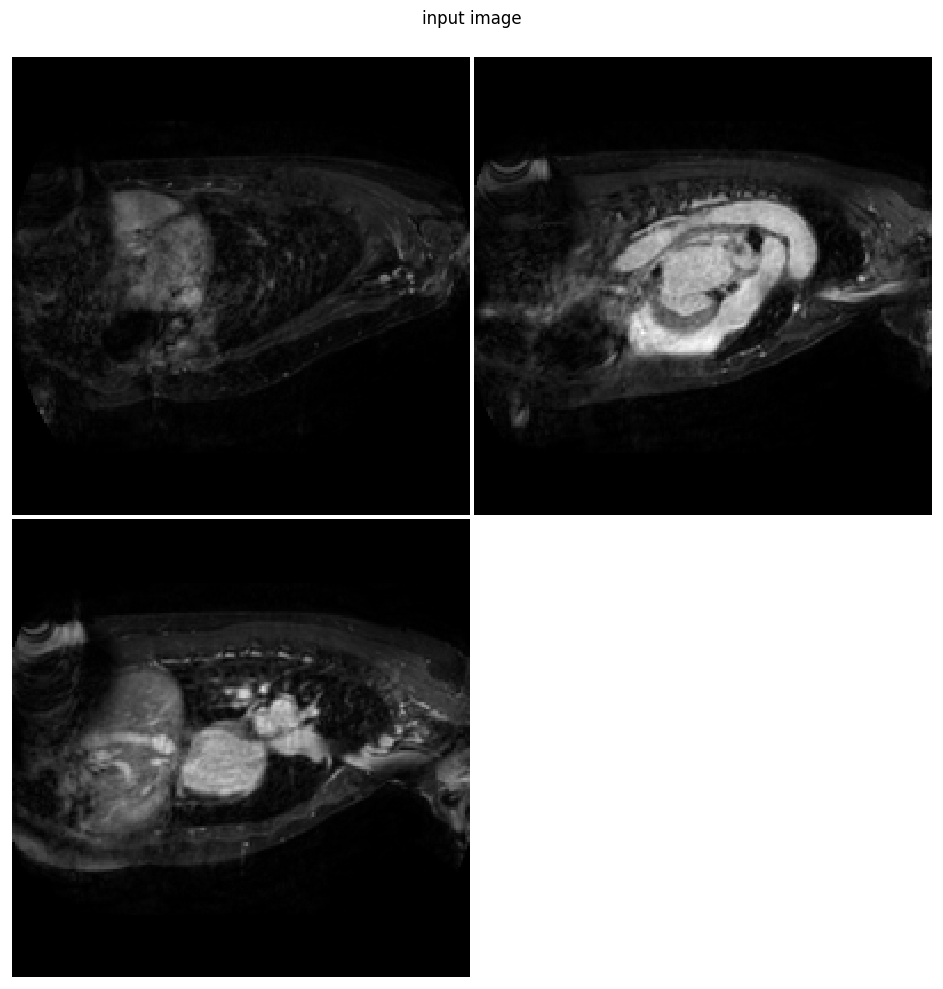

In [ ]:
print(f"image shape: {dataset[0]['image'].shape}")
print(f"label shape: {dataset[0]['label'].shape}")
print(f"pixel spacing: {dataset[0]['image'].pixdim}")
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)
# image의 size가 줄어듬.

Foreground영역의 분할을 할경우 background의 noised영역이 제거 됨으로 cost가 줄어든다.

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


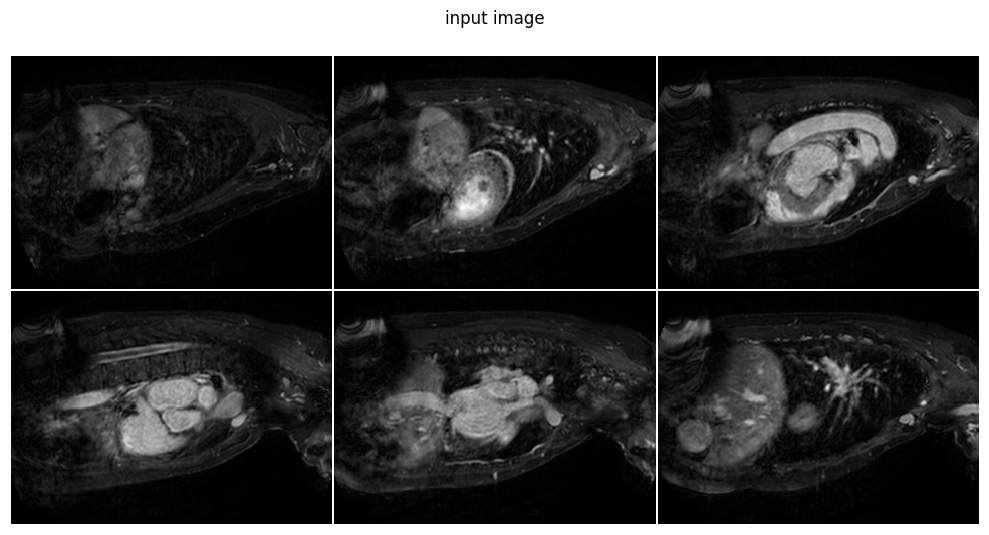

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"), # cropforgroundd는 백그라운드의 noise를 제거
#         NormalizeIntensityd(keys=["image"])
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


In [ ]:
dataset[0]['image'].max()

metatensor(1811.)

In [ ]:
from monai.transforms import NormalizeIntensityd # image에 대한 pixel의 max 값을 변형.

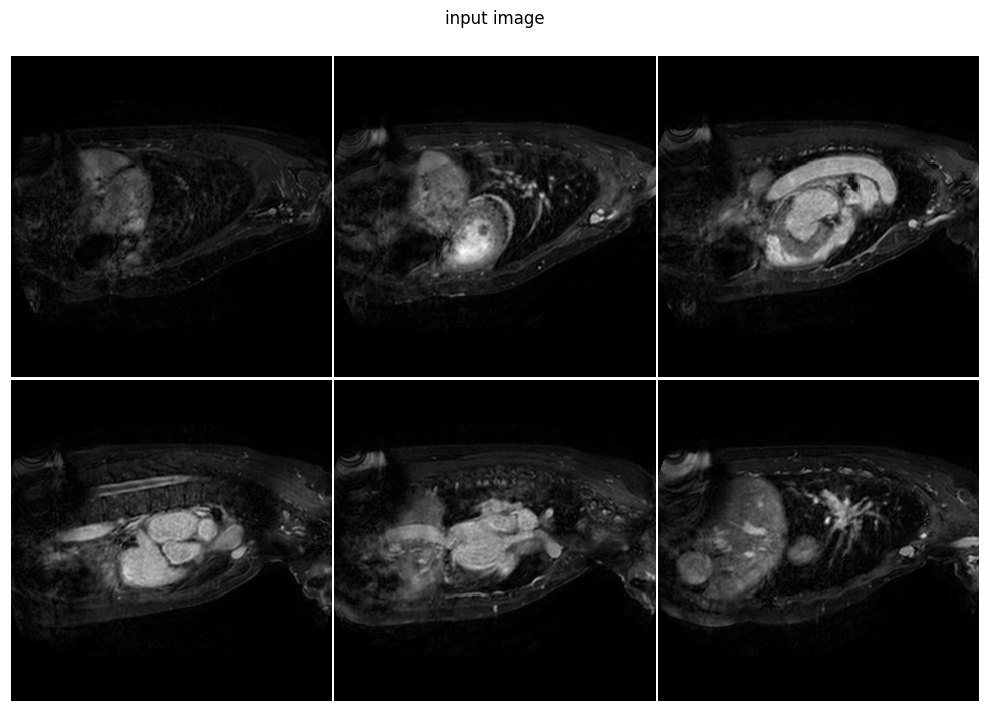

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        NormalizeIntensityd(keys="image", channel_wise=True),
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


In [ ]:
from monai.transforms import (
    EnsureChannelFirstd, ## tesor로 변경하기 위해 channel로 옮김
    LoadImaged, ## nifiti, dicom image 읽어오기
    Spacingd, ## 이미지의 pixel간의 spacing을 interpolationd을 쉽게 해줌
    Orientationd, ## 이미지의 위치를 다시 정렬  Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S).
    ScaleIntensityRanged, # min, max범위를 and scales to (0, 1) 하는 방법
    Compose,  ## 해당 augmentationd을 list로 묶어서 사용
    OneOf, ## 여러 Augmenation중에 하나를 선택하기
    CropForegroundd, ## Foreground부분만 남기는 방법
    Rand3DElasticd, ## 3D 모양으로 Elastic Transform
    RandAffined, ## 이미지의 크기는고정인 상태로 augmenation 함수
    RandRotated, ## random roatate
    RandFlip,
    RandRotate90d,
)


In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=1,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=1,
            max_k=3,
        )

    ])

dataset = Dataset(data=val_data_dicts, transform=transform)


/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


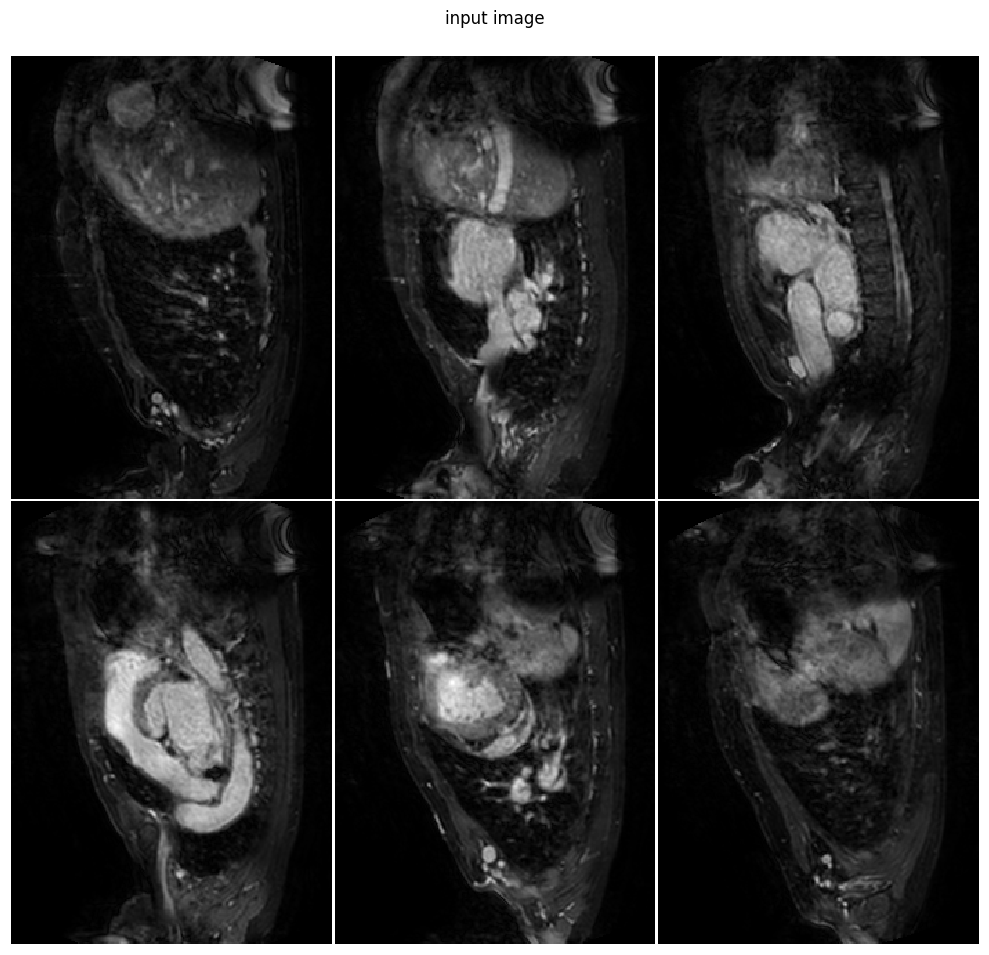

In [ ]:
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


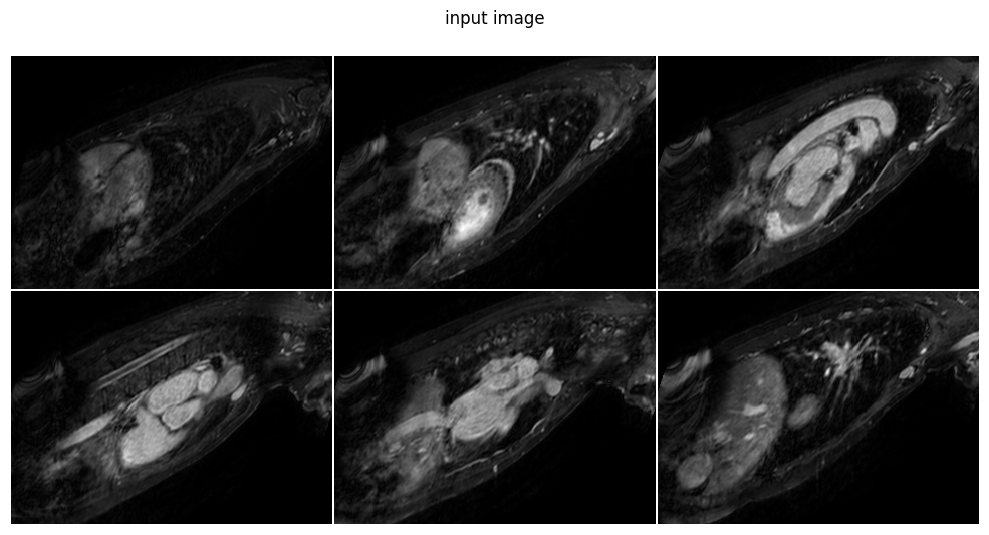

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined( # 이미지를 비틀거나 늘리기
            keys=["image", "label"],
            shear_range=(0.5,0.5), mode='bilinear', padding_mode='zeros',
            prob=1,
        ),
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


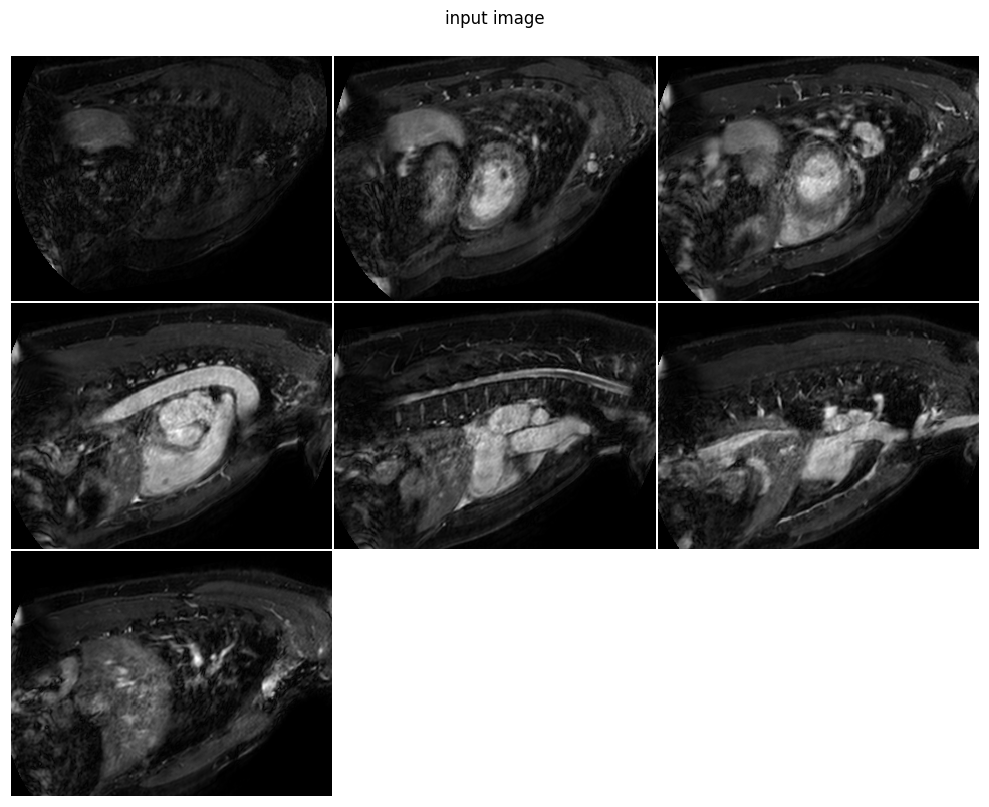

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandAffined(
            keys=["image", "label"],
            shear_range=(0.5,0.5), mode='bilinear', padding_mode='zeros',
            prob=1,
        ),
    ])

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)


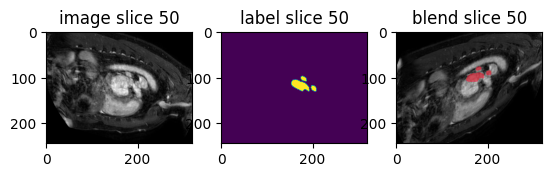

In [ ]:
# affine(데이터를 기하학적으로 변환하는 기법)
import torch
import matplotlib.pyplot as plt
# blend_images를 통해 이미지 + 마스크 섞인 이미지 보기.
ret = blend_images(image=dataset[0]["image"], label=dataset[0]["label"], alpha=0.5, cmap="hsv", rescale_arrays=True)
fig,axs = plt.subplots(1,3)
# plot the slice 50 - 100 of image, label and blend result
slice_index = 10 * 5
axs[0].set_title(f"image slice {slice_index}")
axs[0].imshow(dataset[0]["image"][0, :, :, slice_index], cmap="gray")
axs[1].set_title(f"label slice {slice_index}")
axs[1].imshow(dataset[0]["label"][0, :, :, slice_index])
axs[2].set_title(f"blend slice {slice_index}")
axs[2].imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))

# annotation(컴퓨터가 이해하기 쉽게 라벨 달아줌)

In [ ]:
### hard augmenation
from monai.transforms import (
    RandKSpaceSpikeNoised, ## 주파수 영역의 이미지에서 noise를 추가하여준다 .
    AdjustContrastd, ## 영상의 밝기 조절
    GaussianSmoothd, ## 이미지에 Gaussian을 적용하여 smooth하게 만듬
    RandCoarseDropoutd, ## Cutout처럼 이미지에 특정영역에 box를 적용
    HistogramNormalized, ## 이미지의 histogram을 normalize함으로써 영상의 밝기 향상
)


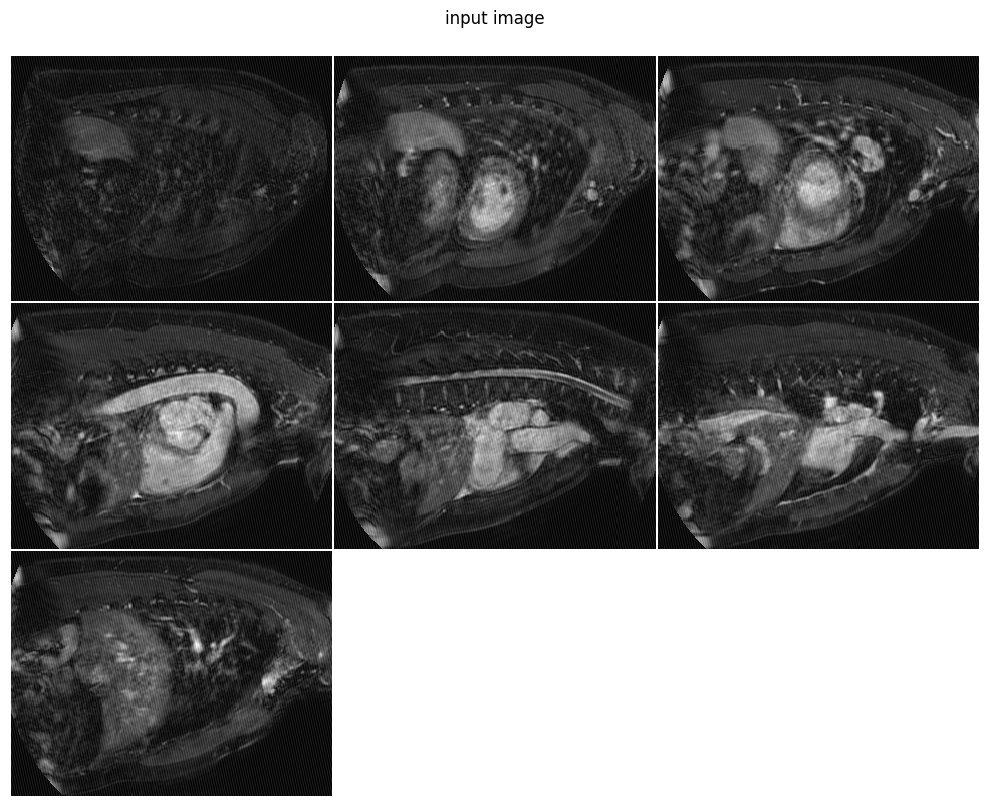

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandKSpaceSpikeNoised(keys=["image"], prob=1, intensity_range=(13, 15), channel_wise=True),
    ])

dataset = Dataset(data=train_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)




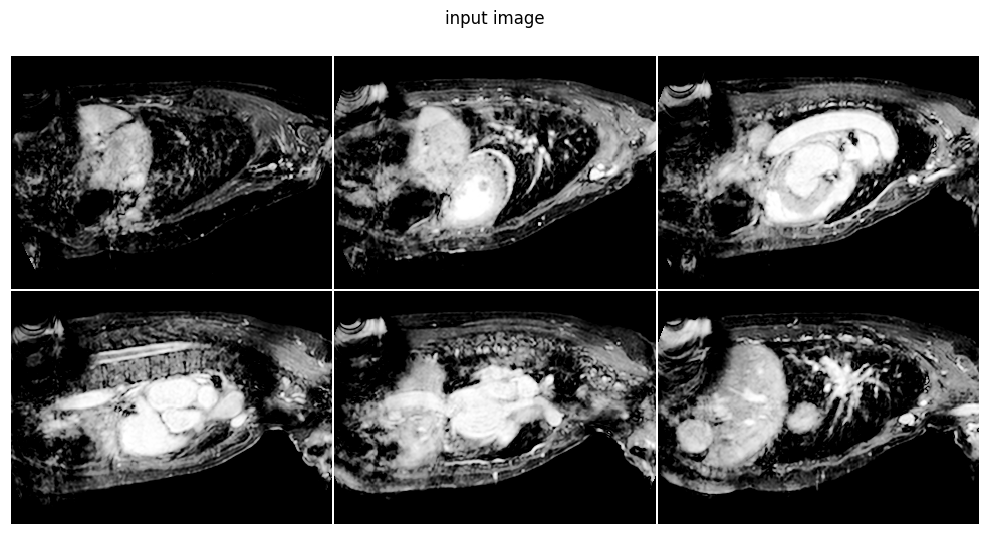

In [ ]:
transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=1800,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        HistogramNormalized(keys=["image"], num_bins=10),
    ])

dataset = Dataset(data=val_data_dicts, transform=transform)
plt = matshow3d(
    volume=dataset[0]["image"][...,1::20],
    fig=None,
    title="input image",
    frame_dim=-1,
    show=True,
    cmap="gray",
)




![스크린샷 2023-12-09 오전 9.37.15.png]

1.   항목 추가
2.   항목 추가

(attachment:82a82802-d8e9-4f47-92b3-24c8f16945d1.png)

torchio

In [ ]:
!pip install torchio

  Obtaining dependency information for torchio from https://files.pythonhosted.org/packages/e8/c0/abed781a834cefb1f469368c72fa8dd28616b2e6bf01e2de3a33c06fe6e3/torchio-0.19.3-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for shellingham<2.0.0,>=1.3.0 from https://files.pythonhosted.org/packages/e0/f9/0595336914c5619e5f28a1fb793285925a8cd4b432c9da0a987836c7f822/shellingham-1.5.4-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.0/173.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
import torchio as tio

# transform = tio.RandomAffine(scales=(1.2, 1.2), degrees=30, translation=10)

![스크린샷 2023-12-16 오후 5.02.05.png](attachment:bd430097-70a8-45a0-b064-65605d32a6dc.png)

In [ ]:
colin = tio.datasets.Colin27()
transforms_dict = {
    tio.RandomAffine(): 0.75,
    tio.RandomElasticDeformation(): 0.25,
}  # Using 3 and 1 as probabilities would have the same effect
transform = tio.OneOf(transforms_dict)

transformed = transform(colin)

24256512it [00:14, 1686491.36it/s]                              


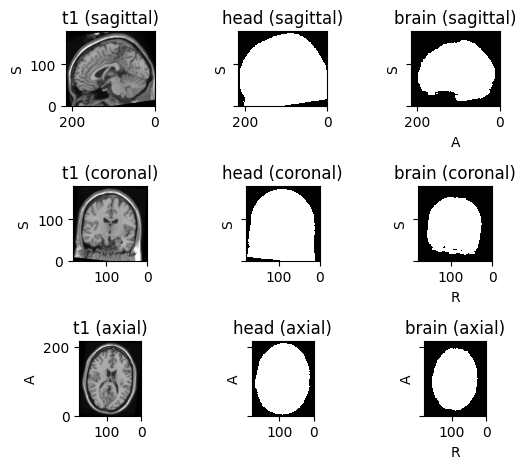

In [ ]:
transformed.plot()

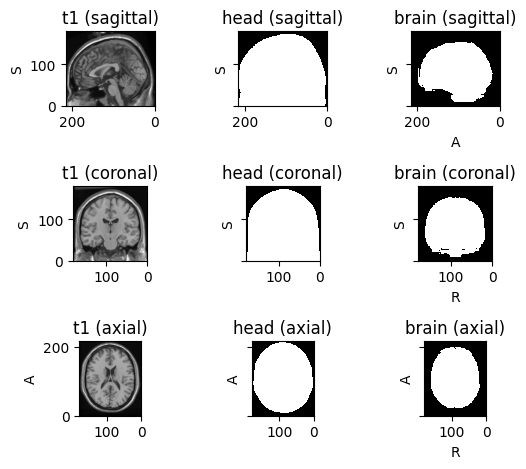

In [ ]:
colin.plot()

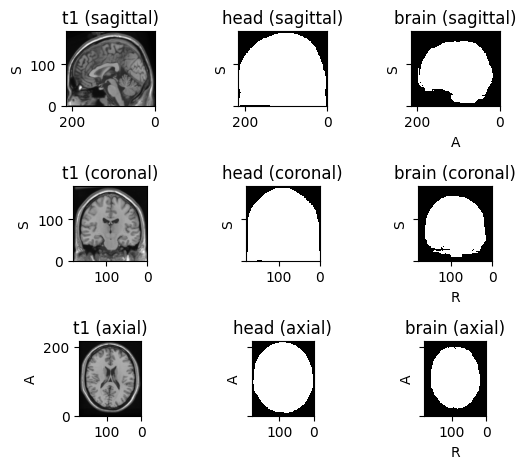

In [ ]:
transformed.plot()